In [1]:
# Import dependencies
import pandas as pd
import sqlalchemy
from sqlalchemy import create_engine, func
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import Column, Integer, String, Float
from sqlalchemy.orm import Session
import datetime as dt
import matplotlib
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt 

In [2]:
# Create the connection engine to the sqlite database
engine = create_engine("sqlite:///data/hawaii.sqlite")

In [3]:
# Establish Base for which classes will be constructed 
Base = automap_base()

In [4]:
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [5]:
# Assign the demographics class to a variable called `Demographics`
Station = Base.classes.stations

In [6]:
# Assign the demographics class to a variable called `Demographics`
Measurement = Base.classes.measurements

In [7]:
# To push the objects made and query the server we use a Session object
session = Session(bind=engine)

<h1>Precipitation Analysis</h1>

In [8]:
# Calculate latest date in measurements table
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

# Convert latest date to datetime object
latest_date_dt = dt.datetime.strptime(latest_date, '%Y-%m-%d')

# Calculate date 12 months ago as datetime object
year_ago_date_dt = latest_date_dt - dt.timedelta(days=365)

# Convert date 12 months ago to string
year_ago_date = year_ago_date_dt.strftime('%Y-%m-%d')

# Print out results
print(f"Most recent date: {latest_date}" + "\n" + f"Date 12 months ago: {year_ago_date}")

Most recent date: 2017-08-23
Date 12 months ago: 2016-08-23


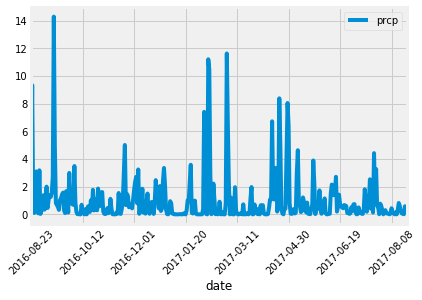

In [12]:
# Retrieve the last 12 months of precipitation data.
last_12_months_precip = session.query(Measurement.date, func.sum(Measurement.prcp))\
                    .filter(Measurement.date >= year_ago_date)\
                    .group_by(Measurement.date)\
                    .order_by(Measurement.date).all()
              
#Load the query results into a Pandas DataFrame and set the index to the date column. 
last_12_months_precip_df = pd.DataFrame(last_12_months_precip, columns=['date', 'prcp'])
last_12_months_precip_df = last_12_months_precip_df.set_index('date')

#Plot the results using the DataFrame plot method.
last_12_months_precip_df.plot()

# Rotate the xticks for the dates
plt.xticks(rotation='45')
plt.show() 

In [14]:
last_12_months_precip_df.describe()

,prcp
count,366.000000
mean,0.978907
std,1.776349
min,0.000000
25%,0.052500
50%,0.405000
75%,1.087500
max,14.280000


<h1>Station Analysis</h1>

In [17]:
# Calculate the total number of stations.
station_count = session.query(Station.station).count()
print(f"There are {station_count} stations." + "\n")

# Find the most active stations.
stations_by_measurements = session.query(Measurement.station, func.count(Measurement.tobs))\
                        .group_by(Measurement.station)\
                        .order_by(Measurement.tobs.desc()).first()
most_active_station = stations_by_measurements[0]
most_active_station_obs = stations_by_measurements[1]
print(f"The most active station is {most_active_station} with {most_active_station_obs} measurements." + "\n")

# List the stations and observation counts in descending order
# Which station has the highest number of observations?

stations_by_obs = session.query(Measurement.station, func.sum(Measurement.tobs))\
                    .group_by(Measurement.station)\
                    .order_by(func.sum(Measurement.tobs).desc()).all()
print("List of stations and number of observations" + "\n", stations_by_obs, "\n")
station_max_obs_name = stations_by_obs[0][0]
station_max_obs_tobs = stations_by_obs[0][1]
print("The station with the highest number of observations is", station_max_obs_name, "with", station_max_obs_tobs,
     "observations.")

# Retrieve the last 12 months of temperature observation data (tobs).
# Filtered by the station with the highest number of observations.
tobs_by_max_station = session.query(Measurement.tobs)\
                    .filter(Measurement.date >= year_ago_date)\
                    .filter(Measurement.station == station_max_obs_name).all()

There are 9 stations.

The most active station is USC00514830 with 1937 measurements.

List of stations and number of observations
 [('USC00519397', 200205), ('USC00519281', 198652), ('USC00513117', 195940), ('USC00519523', 191698), ('USC00516128', 176029), ('USC00514830', 144913), ('USC00511918', 138191), ('USC00517948', 50943), ('USC00518838', 24855)] 

The station with the highest number of observations is USC00519397 with 200205 observations.


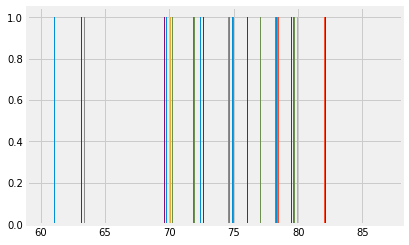

In [18]:
#Plot the results as a histogram with bins=12.
plt.hist(tobs_by_max_station, bins=12)
plt.show()